In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt 

In [3]:
image_folders = [
    "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/cv-learnings/coco_ankiita/SD2Q/Train/Facebook",
    "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/cv-learnings/coco_ankiita/SD2Q/Train/Instagram",
    "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/cv-learnings/coco_ankiita/SD2Q/Train/Instagram",
    "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/cv-learnings/coco_ankiita/SD2Q/Train/Telegram",
]

In [4]:
import torch
import torch.nn as nn

class ViT(nn.Module):
    def __init__(self, num_classes=4, embed_dim=256, num_heads=8, num_layers=8, mlp_dim=512, conv_dim=64, dropout_rate=0.1):
        super(ViT, self).__init__()
        self.embed_dim = embed_dim
        self.patch_size = 16
        self.num_patches = (224 // self.patch_size) ** 2

        # Convolutional layers before patch embedding
        self.pre_conv = nn.Sequential(
            nn.Conv2d(3, conv_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(),
            nn.Conv2d(conv_dim, conv_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(),
            nn.Conv2d(conv_dim, conv_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(),
        )

        # Patch embedding
        self.patch_embed = nn.Conv2d(in_channels=conv_dim, out_channels=embed_dim, kernel_size=self.patch_size, stride=self.patch_size)
        self.norm = nn.LayerNorm(embed_dim)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        # Transformer encoder layers with more layers and heads
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=mlp_dim, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Additional Feed-Forward Network (FFN) layers
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )

        # Classification head
        self.fc = nn.Linear(mlp_dim, num_classes)

    def forward(self, x):
        # Convolutional layers before patch embedding
        x = self.pre_conv(x)  # Capture more local features

        # Patch embedding
        x = self.patch_embed(x)  # Shape: [batch_size, embed_dim, num_patches, patch_size]
        x = x.flatten(2).transpose(1, 2)  # Shape: [batch_size, num_patches, embed_dim]
        x = self.norm(x)  # Apply normalization

        # Add positional encoding
        x = x + self.positional_encoding

        # Transformer encoder
        x = self.transformer_encoder(x)  # Shape: [batch_size, num_patches, embed_dim]

        # Additional FFN layers
        x = self.ffn(x.mean(dim=1))  # Aggregate patch embeddings and apply FFN
        
        # Classification head
        x = self.fc(x)
        return x


In [5]:

# class ViT(nn.Module):
#     def __init__(self, num_classes=4, embed_dim=128, num_heads=4, num_layers=4, mlp_dim=256):
#         super(ViT, self).__init__()
#         self.embed_dim = embed_dim
#         self.patch_size = 16
#         self.num_patches = (224 // self.patch_size) ** 2

#         # Patch embedding
#         self.patch_embed = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=self.patch_size, stride=self.patch_size)

#         # Positional encoding
#         self.positional_encoding = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

#         # Transformer encoder layers
#         encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=mlp_dim)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # Classification head
#         self.fc = nn.Linear(embed_dim, num_classes)

#     def forward(self, x):
#         # Patch embedding
#         x = self.patch_embed(x)  # Shape: [batch_size, embed_dim, num_patches, patch_size]
#         x = x.flatten(2).transpose(1, 2)  # Shape: [batch_size, num_patches, embed_dim]

#         # Add positional encoding
#         x = x + self.positional_encoding

#         # Transformer encoder
#         x = self.transformer_encoder(x)  # Shape: [batch_size, num_patches, embed_dim]

#         # Classification head
#         x = x.mean(dim=1)  # Aggregate patch embeddings
#         x = self.fc(x)
#         return x

In [6]:
# Define a custom dataset class
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

image_paths = []
labels = []
for i, folder in enumerate(image_folders):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        image_paths.append(img_path)
        labels.append(i)

# Define transformations and dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = ImageDataset(image_paths, labels, transform=transform)
train_loader = DataLoader(dataset, batch_size=512, shuffle=True)

/opt/anaconda3/envs/rishabh_sat/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 6/6 [02:37<00:00, 26.19s/it]


Epoch 5/100, Loss: 1.3871


100%|██████████| 6/6 [02:31<00:00, 25.22s/it]


Epoch 10/100, Loss: 1.3869


100%|██████████| 6/6 [02:30<00:00, 25.04s/it]


Epoch 15/100, Loss: 1.3871


100%|██████████| 6/6 [02:30<00:00, 25.11s/it]


Epoch 20/100, Loss: 1.3872


100%|██████████| 6/6 [02:36<00:00, 26.09s/it]


Epoch 25/100, Loss: 1.3869


100%|██████████| 6/6 [02:35<00:00, 25.99s/it]


Epoch 30/100, Loss: 1.3871


100%|██████████| 6/6 [02:36<00:00, 26.15s/it]


Epoch 35/100, Loss: 1.3871


100%|██████████| 6/6 [02:36<00:00, 26.02s/it]


Epoch 40/100, Loss: 1.3868


100%|██████████| 6/6 [02:29<00:00, 24.96s/it]


Epoch 45/100, Loss: 1.3868


100%|██████████| 6/6 [02:29<00:00, 24.97s/it]


Epoch 50/100, Loss: 1.3870


100%|██████████| 6/6 [02:33<00:00, 25.56s/it]


Epoch 55/100, Loss: 1.3867


100%|██████████| 6/6 [02:33<00:00, 25.66s/it]


Epoch 60/100, Loss: 1.3873


100%|██████████| 6/6 [02:33<00:00, 25.62s/it]


Epoch 65/100, Loss: 1.3868


100%|██████████| 6/6 [02:33<00:00, 25.62s/it]


Epoch 70/100, Loss: 1.3866


100%|██████████| 6/6 [02:33<00:00, 25.66s/it]


Epoch 75/100, Loss: 1.3869


100%|██████████| 6/6 [02:33<00:00, 25.64s/it]


Epoch 80/100, Loss: 1.3869


100%|██████████| 6/6 [02:34<00:00, 25.69s/it]


Epoch 85/100, Loss: 1.3867


100%|██████████| 6/6 [02:35<00:00, 25.85s/it]


Epoch 90/100, Loss: 1.3864


100%|██████████| 6/6 [02:30<00:00, 25.14s/it]


Epoch 95/100, Loss: 1.3867


100%|██████████| 6/6 [02:30<00:00, 25.12s/it]


Epoch 100/100, Loss: 1.3866


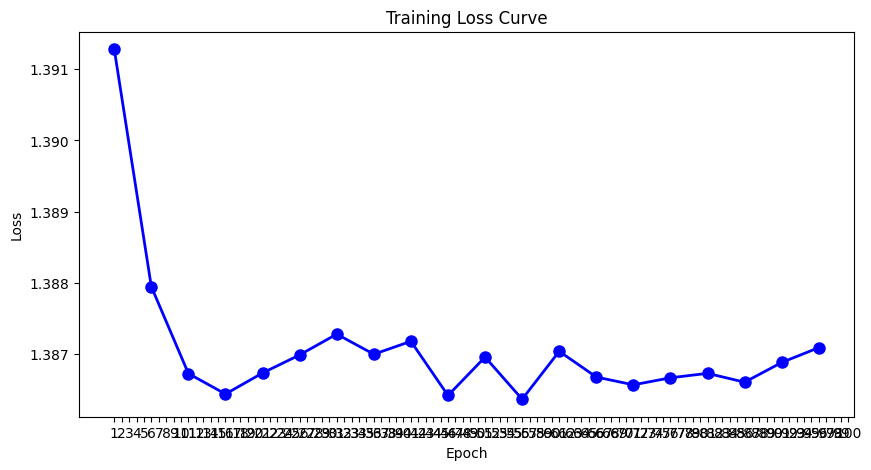

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(num_classes=len(image_folders))
model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 100
model.train()

# Initialize a list to store loss values for plotting
epoch_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)  # Append the loss for this epoch
    # Print the loss after 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
# Save the trained model
torch.save(model.state_dict(), "vit_classification_model.pth")

# Plot the training loss curve
plt.figure(figsize=(10, 5))
#plot the loss curve after every 5 epochs
plt.plot(range(1, num_epochs + 1, 5), epoch_losses[::5], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
# plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
# plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.show()

In [8]:
# Set test path
test_path = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/cv-learnings/coco_ankiita/SD2Q/Test"

# Define the test image folders and corresponding labels
image_folders = [
    "Facebook",
    "Instagram",
    "Telegram",
    "Whatsapp",
]
test_image_paths = []
test_labels = []

# Loop through each folder and collect image paths and labels
for i, folder in enumerate(image_folders):
    folder_path = os.path.join(test_path, folder)
    if os.path.exists(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            test_image_paths.append(img_path)
            test_labels.append(i)
    else:
        print(f"Warning: {folder_path} does not exist.")

# Define transformations for the test set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create test dataset and dataloader
test_dataset = ImageDataset(test_image_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


Accuracy: 25.00%
Average Loss: 1.3863


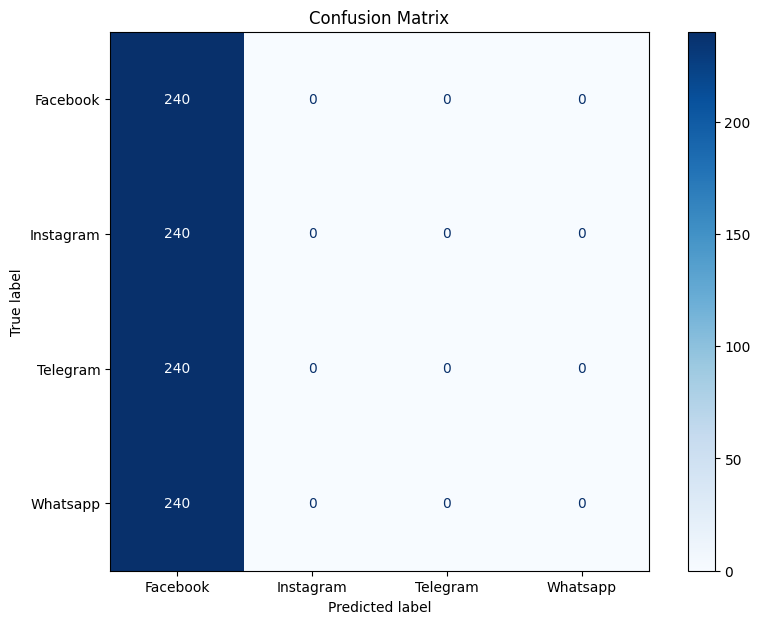

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    average_loss = running_loss / len(test_loader)
    
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Average Loss: {average_loss:.4f}')

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=list(range(len(image_folders))))
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Folder {i+1}' for i in range(len(image_folders))])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=image_folders)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

    return average_loss

# Evaluate on test set
test_loss = evaluate_model(model, test_loader)
